In [1]:
# Testing sample las with swath function
import sys
import os
sys.path.append('Modules/demCreationComponents/')
import math
import pdal
import json
import pointCloudCreation as pCC

from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import inv, det

from importlib import reload
import geopandas as gpd
from shapely.geometry import LineString, Point

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn import cluster
from scipy.signal import fftconvolve    # Gaussian Filter
from scipy.signal import savgol_filter

print(os.getcwd())

%matplotlib widget
%matplotlib inline

/workspaces/rgr/src


## SAMPLE POINTCLOUD WITH PROFILE LINES

Params for Lidar Sampling

In [2]:
# Open profile line shapefile
pathToLine = os.path.join('profiles_for_project', 'profiles_for_project.shp')
line_GDF = gpd.read_file(pathToLine)
print(line_GDF.head)
print(line_GDF.columns)

# set sampling params
swath_width = 5 # width of strike-perendicular swaths; 5 for drone, lidar, pleiades, 90 for UTM
nProfiles = len(line_GDF) #Number of profiles we will construct
outEPSG = 32613
usgs_survey_name = 'CO_San-Luis-Valley_2011'
swathWidth = swath_width

loc_list = ['Zapata (Single-strand Fault)', 'Zapata (Multi-strand Fault)', 'Pinon', 'Graben (Upper Fault)', 'Graben (Lower Fault)', 'Tobin']


<bound method NDFrame.head of    Id             Name                                           geometry
0   0  SZ SingleStrand  LINESTRING (449301.370 4164131.198, 449270.694...
1   0   SZ MultiStrand  LINESTRING (449269.303 4163978.344, 449179.713...
2   0            Pinon  LINESTRING (454362.970 4174234.724, 454352.993...
3   0     Graben Upper  LINESTRING (455269.565 4175002.098, 455213.286...
4   0     Graben Lower  LINESTRING (455134.664 4174991.007, 455076.495...
5   0            Tobin  LINESTRING (452211.741 4155195.776, 452150.596...>
Index(['Id', 'Name', 'geometry'], dtype='object')


Get points from AWS cloud using profile lines & PDAL

In [3]:
#nProfiles
horiz_pts_list = []
elev_pts_list = []

plotInterval = 5 

for n in range(nProfiles):
    
    profLine = line_GDF.geometry[n]
    #print(profLine)
    
    #Execute the pipeline
    pipe = pCC.get_swathprofile_request_pointcloud(profLine,swathWidth,outEPSG,usgs_survey_name,'profileTest',doSavePointCloud=False,doReclassify = True)

    #Get the relevant data from the pipeline
    arrays = pipe.arrays[0]

    profileLength = np.max(arrays['L'])
    L = np.array(arrays['L']) #- profileLength/2
    Z = np.array(arrays['Z'])
    C = np.array(arrays['Classification'])
    D = np.array(arrays['D'])
    X = np.array(arrays['X'])
    Y = np.array(arrays['Y'])
    
    #Which points are ground:
    isGrnd = C == 2
    
    # create arrays of profile horizontal dist & elevation values
    Horiz_dist = L[isGrnd][::plotInterval]
    Elev = Z[isGrnd][::plotInterval]
    
    horiz_pts_list.append(Horiz_dist)
    elev_pts_list.append(Elev)


## Load GPS Data

In [4]:
#path to GPS shapefile
                        # folder name              #shp with gps points 
#pathToGPS = os.path.join('geo7x_sangres_all_shp', 'geo7x_gps_merg.shp') # see cell In [85] for notes
pathToGPS = os.path.join('geo7x_sangres_all_shp', 'Point_Proj.shp')
print(pathToGPS)
#read shp w/geopandas
gps_GDF = gpd.read_file(pathToGPS)
print(gps_GDF.columns) 
print(gps_GDF.crs)

print(gps_GDF['Site'].unique()) # Get name of each study site

# Split GPS DF by study site
mask_Tobin_GPS = gps_GDF['Site'] == 'Tobin'
mask_SZsingle_GPS = gps_GDF['Site'] == 'SZ SingleStrand'
mask_SZmulti_GPS = gps_GDF['Site'] == 'SZ MultiStrand'
mask_Pinon_GPS = gps_GDF['Site'] == 'Pinon'
mask_GrabenU_GPS = gps_GDF['Site'] == 'Graben Upper'
mask_GrabenL_GPS = gps_GDF['Site'] == 'Graben Lower'

# New GPS df for each site:
Tobin_GPS = gpd.GeoDataFrame(gps_GDF[mask_Tobin_GPS])
SZ_single_GPS = gpd.GeoDataFrame(gps_GDF[mask_SZsingle_GPS])
SZ_multi_GPS = gpd.GeoDataFrame(gps_GDF[mask_SZmulti_GPS])
Pinon_GPS = gpd.GeoDataFrame(gps_GDF[mask_Pinon_GPS])
GrabenU_GPS = gpd.GeoDataFrame(gps_GDF[mask_GrabenU_GPS])
GrabenL_GPS = gpd.GeoDataFrame(gps_GDF[mask_GrabenL_GPS])

geo7x_sangres_all_shp/Point_Proj.shp
Index(['Name', 'Descriptio', 'Layer', 'FeatureCod', 'Easting', 'Northing',
       'Elevation', 'GlobalLati', 'GlobalLong', 'GlobalElli', 'LocalLatit',
       'LocalLongi', 'LocalEllip', 'H_Prec_Obs', 'V_Prec_Obs', 'Date_Obs',
       'Time_Obs', 'Site', 'geometry'],
      dtype='object')
epsg:32613
['Graben Upper' 'Graben Lower' 'Pinon' 'Tobin' 'SZ SingleStrand'
 'SZ MultiStrand' 'CORRS Station(?)']


In [5]:
# Split Profile line shp by study site
print(line_GDF.head)
print(line_GDF.crs)
# Create new DFs for each Location's profile projection line
mask_Tobin_Line = line_GDF['Name'] == 'Tobin'
mask_SZsingle_Line = line_GDF['Name'] == 'SZ SingleStrand'
mask_SZmulti_Line = line_GDF['Name'] == 'SZ MultiStrand'
mask_Pinon_Line = line_GDF['Name'] == 'Pinon'
mask_GrabenU_Line = line_GDF['Name'] == 'Graben Upper'
mask_GrabenL_Line = line_GDF['Name'] == 'Graben Lower'

# new gp dataframe of just specific mapunit
Tobin_Line = gpd.GeoDataFrame(line_GDF[mask_Tobin_Line])
SZ_single_Line = gpd.GeoDataFrame(line_GDF[mask_SZsingle_Line])
SZ_multi_Line = gpd.GeoDataFrame(line_GDF[mask_SZmulti_Line])
Pinon_Line = gpd.GeoDataFrame(line_GDF[mask_Pinon_Line])

#Graben lines are separate; mask both, then combine w/ pandas concat
GrabenU_Line = gpd.GeoDataFrame(line_GDF[mask_GrabenU_Line])
GrabenL_Line = gpd.GeoDataFrame(line_GDF[mask_GrabenL_Line])

<bound method NDFrame.head of    Id             Name                                           geometry
0   0  SZ SingleStrand  LINESTRING (449301.370 4164131.198, 449270.694...
1   0   SZ MultiStrand  LINESTRING (449269.303 4163978.344, 449179.713...
2   0            Pinon  LINESTRING (454362.970 4174234.724, 454352.993...
3   0     Graben Upper  LINESTRING (455269.565 4175002.098, 455213.286...
4   0     Graben Lower  LINESTRING (455134.664 4174991.007, 455076.495...
5   0            Tobin  LINESTRING (452211.741 4155195.776, 452150.596...>
epsg:32613


# ZAPATA STUDY SITE PROFILES

 ### Zapata Single Strand

Text(0, 0.5, 'Elevation (m)')

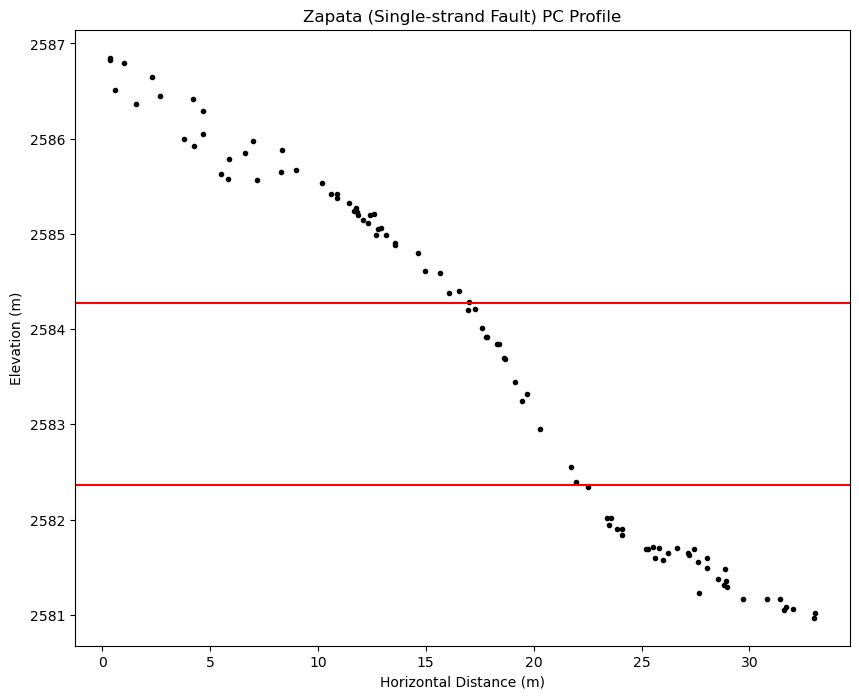

In [6]:
## LIDAR PC PROFILE
f,axs = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

axs.plot(horiz_pts_list[0],elev_pts_list[0],'.',color = 'k')
#plt.axline((x1, y1), (x2, y2))
axs.axhline(y = 2584.277, color = 'r', linestyle = '-')
axs.axhline(y = 2582.36, color = 'r', linestyle = '-')

axs.set_title(loc_list[0] + ' PC Profile')
axs.set_xlabel('Horizontal Distance (m)')
axs.set_ylabel('Elevation (m)')


0.0


Text(0, 0.5, 'Elevation (m)')

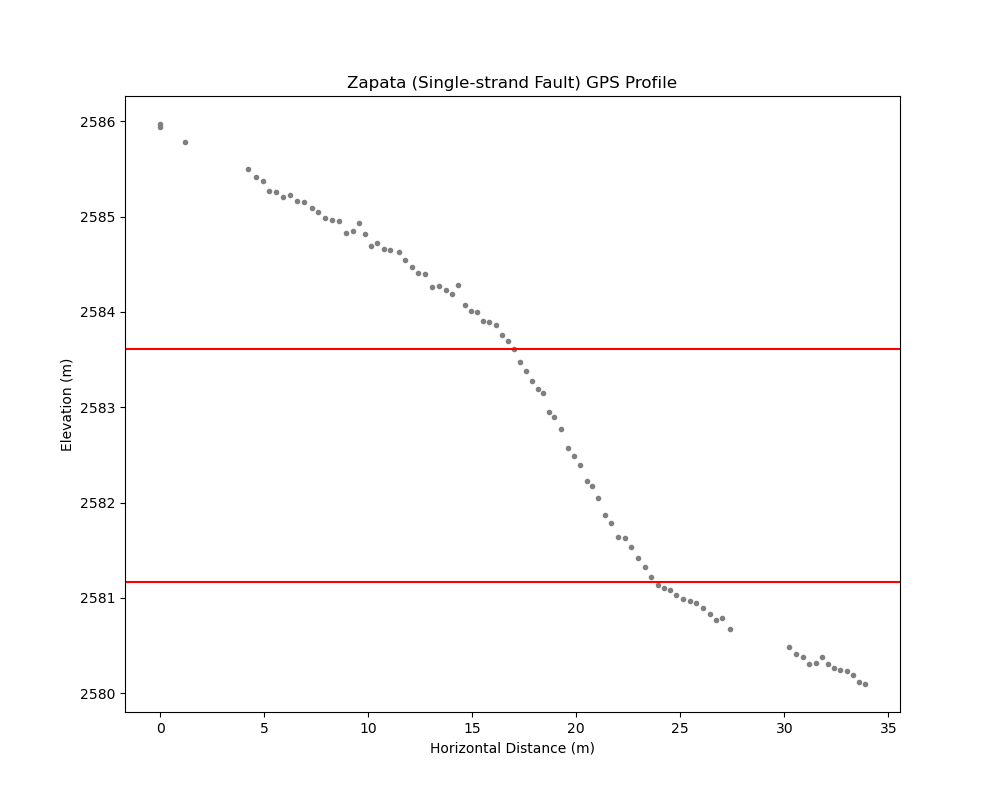

In [7]:
# GPS Profile
# Convert geometries to np arrays
x,y = SZ_single_GPS.geometry.x,SZ_single_GPS.geometry.y
PointsXY = [np.array(t) for t in zip(x,y)]

xL,yL = SZ_single_Line.geometry[SZ_single_Line.geometry.index[0]].xy
LineXY = [np.array(t) for t in zip(x,y)]

#compare line & point locations to check placement
print(np.sum((LineXY[0] - PointsXY[0])**2))

SZs_proj_dist,SZs_profile_dist = pCC.projectPointsOntoLine(LineXY, PointsXY) 
%matplotlib widget
f,ax = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
ax.plot(SZs_profile_dist,SZ_single_GPS['Elevation'],'.',color = 'grey', alpha = 1)
ax.axhline(y = 2583.61, color = 'r', linestyle = '-')
ax.axhline(y = 2581.17, color = 'r', linestyle = '-')

ax.set_title(loc_list[0] + ' GPS Profile')
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')

### Zapata Multi-strand

Text(0, 0.5, 'Elevation (m)')

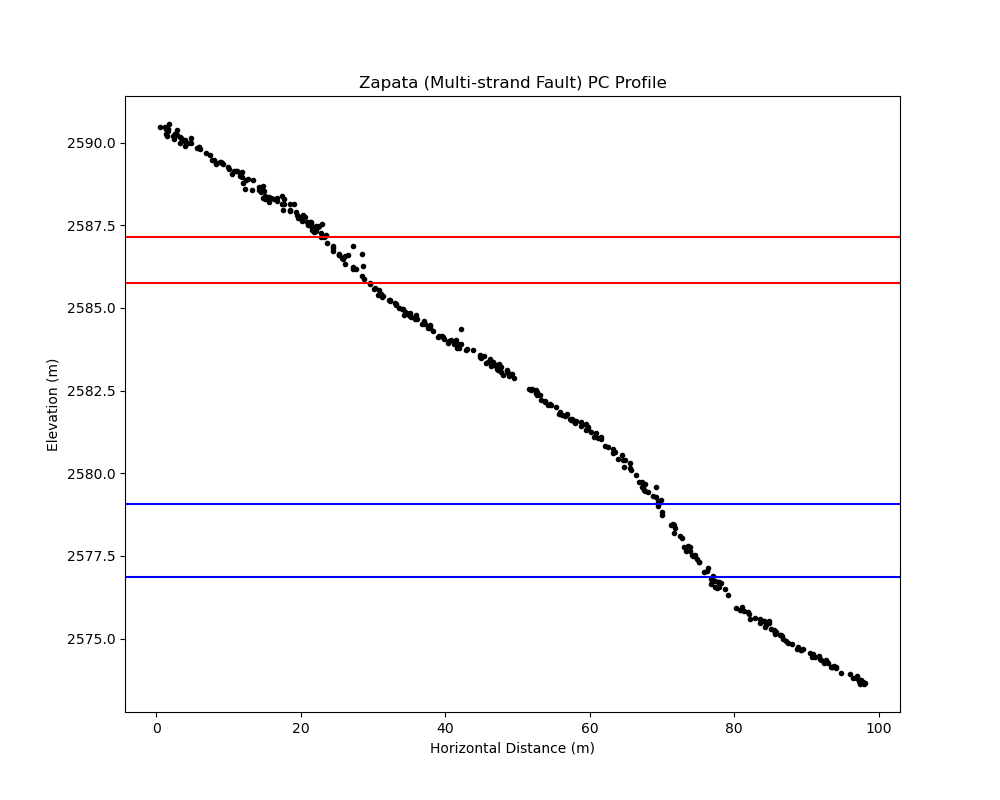

In [8]:
# LIDAR PC PROFILE
f,axs = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

axs.plot(horiz_pts_list[1],elev_pts_list[1],'.',color = 'k')
axs.axhline(y = 2587.13, color = 'r', linestyle = '-')
axs.axhline(y = 2585.76, color = 'r', linestyle = '-')

axs.axhline(y = 2579.08, color = 'b', linestyle = '-')
axs.axhline(y = 2576.85, color = 'b', linestyle = '-')
axs.set_title(loc_list[1]+ ' PC Profile')
axs.set_xlabel('Horizontal Distance (m)')
axs.set_ylabel('Elevation (m)')


0.0


Text(0, 0.5, 'Elevation (m)')

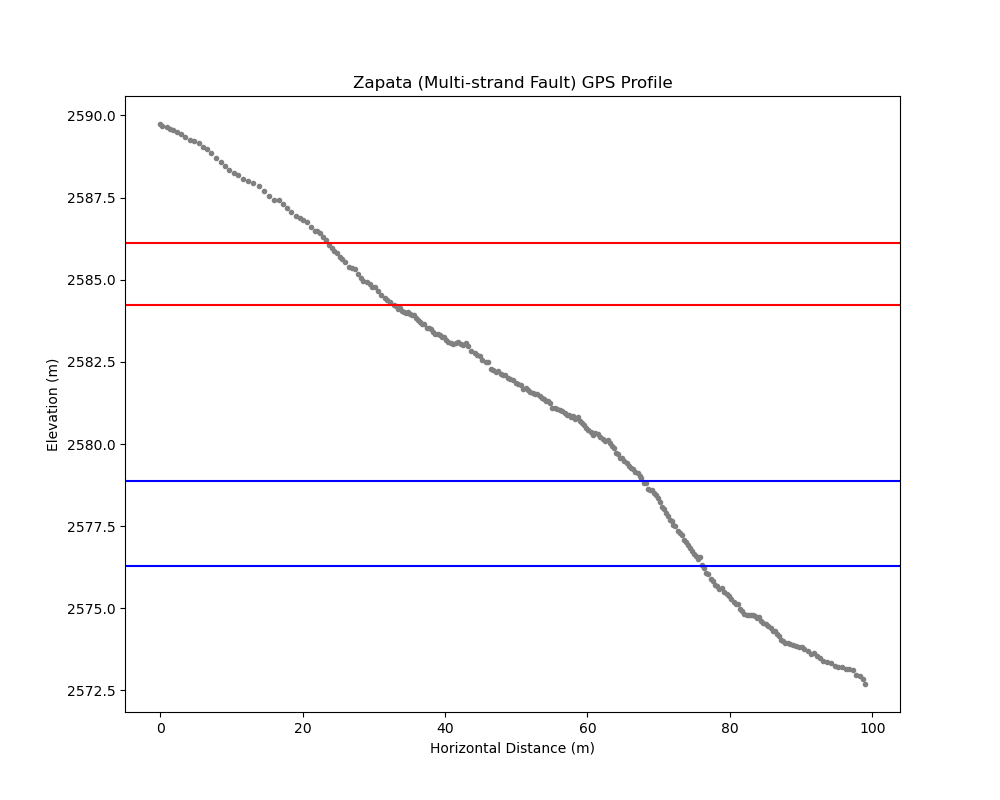

In [9]:
# GPS Profile
# Convert geometries to np arrays
x,y = SZ_multi_GPS.geometry.x,SZ_multi_GPS.geometry.y
PointsXY = [np.array(t) for t in zip(x,y)]

xL,yL = SZ_multi_Line.geometry[SZ_multi_Line.geometry.index[0]].xy
LineXY = [np.array(t) for t in zip(x,y)]

#compare line & point locations to check placement
print(np.sum((LineXY[0] - PointsXY[0])**2))

SZm_proj_dist,SZm_profile_dist = pCC.projectPointsOntoLine(LineXY, PointsXY) 
%matplotlib widget
f,ax = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
ax.plot(SZm_profile_dist,SZ_multi_GPS['Elevation'],'.',color = 'grey', alpha = 1)
ax.set_title(loc_list[1] + ' GPS Profile')
ax.axhline(y = 2586.12, color = 'r', linestyle = '-')
ax.axhline(y = 2584.23, color = 'r', linestyle = '-')

ax.axhline(y = 2578.87, color = 'b', linestyle = '-')
ax.axhline(y = 2576.29, color = 'b', linestyle = '-')

ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')

# PINON STUDY SITE

No such comm: 7d426fc7bdd84aa98dde6080133bac37


No such comm: 8a212394843741d584e738320f013d68


Text(0, 0.5, 'Elevation (m)')

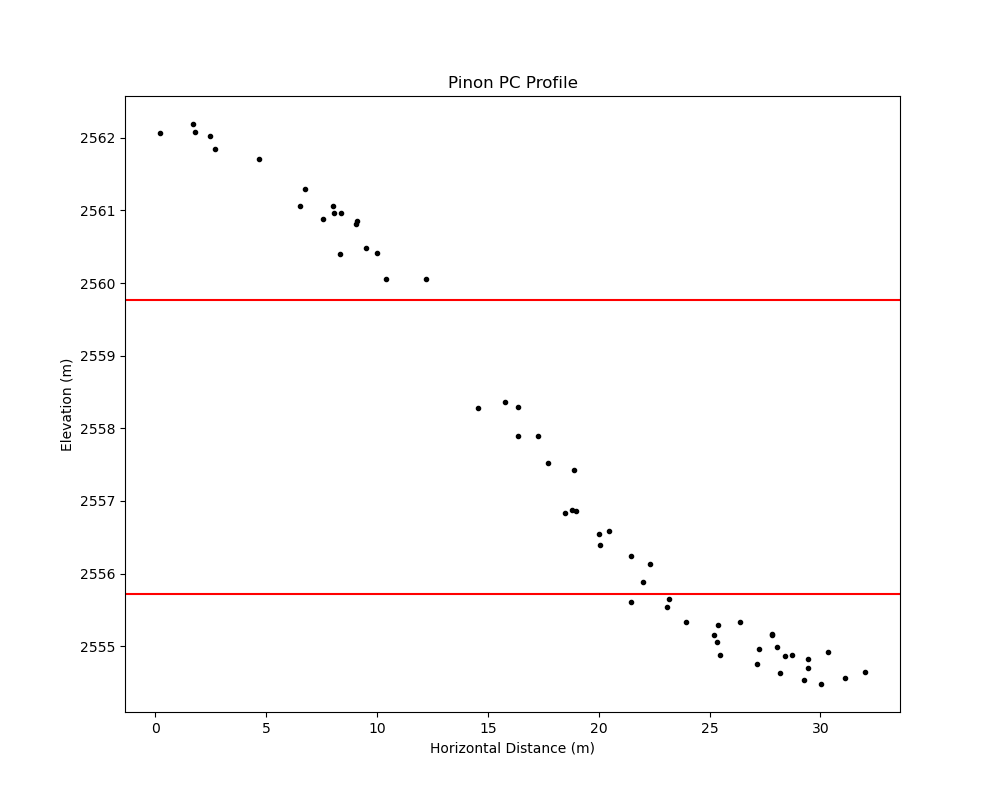

In [10]:

f,axs = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

axs.plot(horiz_pts_list[2],elev_pts_list[2],'.',color = 'k')
axs.axhline(y =  2559.76, color = 'r', linestyle = '-')
axs.axhline(y = 2555.72, color = 'r', linestyle = '-')
axs.set_title(loc_list[2] + ' PC Profile')
axs.set_xlabel('Horizontal Distance (m)')
axs.set_ylabel('Elevation (m)')


0.0


Text(0, 0.5, 'Elevation (m)')

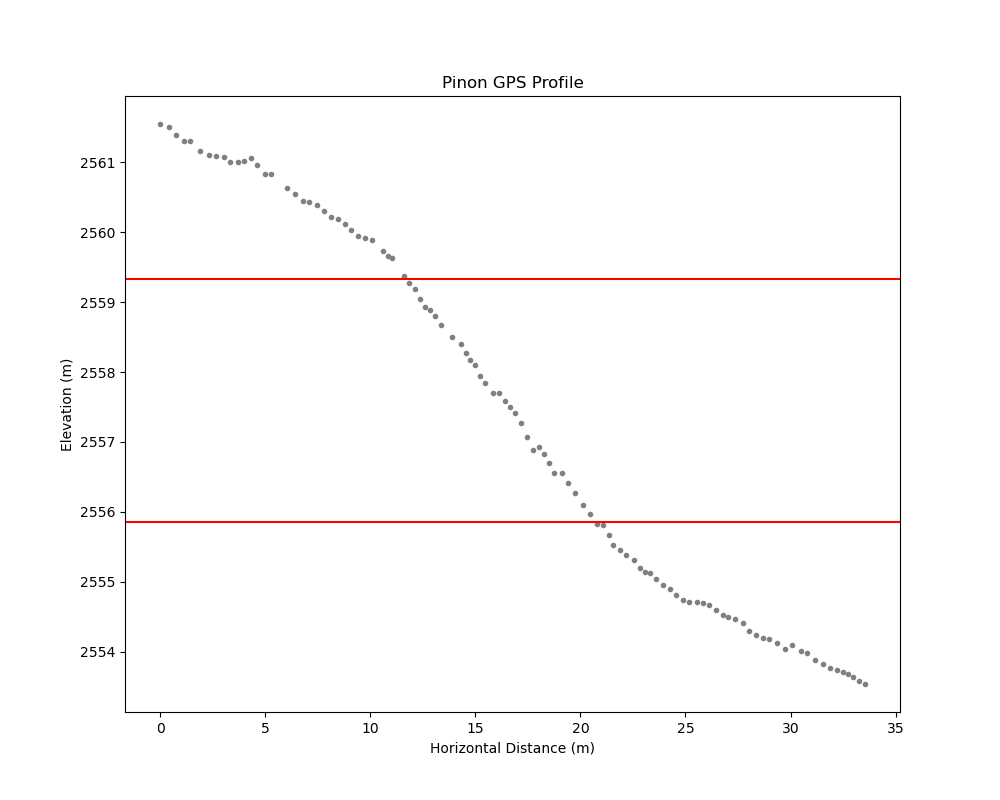

In [11]:
# GPS Profile
# Convert geometries to np arrays
x,y = Pinon_GPS.geometry.x,Pinon_GPS.geometry.y
PointsXY = [np.array(t) for t in zip(x,y)]

xL,yL = Pinon_Line.geometry[Pinon_Line.geometry.index[0]].xy
LineXY = [np.array(t) for t in zip(x,y)]

#compare line & point locations to check placement
print(np.sum((LineXY[0] - PointsXY[0])**2))

Pin_proj_dist,Pin_profile_dist = pCC.projectPointsOntoLine(LineXY, PointsXY) 
%matplotlib widget
f,ax = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
ax.plot(Pin_profile_dist,Pinon_GPS['Elevation'],'.',color = 'grey', alpha = 1)

ax.axhline(y = 2559.33, color = 'r', linestyle = '-')
ax.axhline(y = 2555.85, color = 'r', linestyle = '-')

ax.set_title(loc_list[2] + ' GPS Profile')
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')

# GRABEN STUDY SITE

### Upper Graben

No such comm: 719aa1a5f8cf4ce2b1de6a130279c4ce


Text(0, 0.5, 'Elevation (m)')

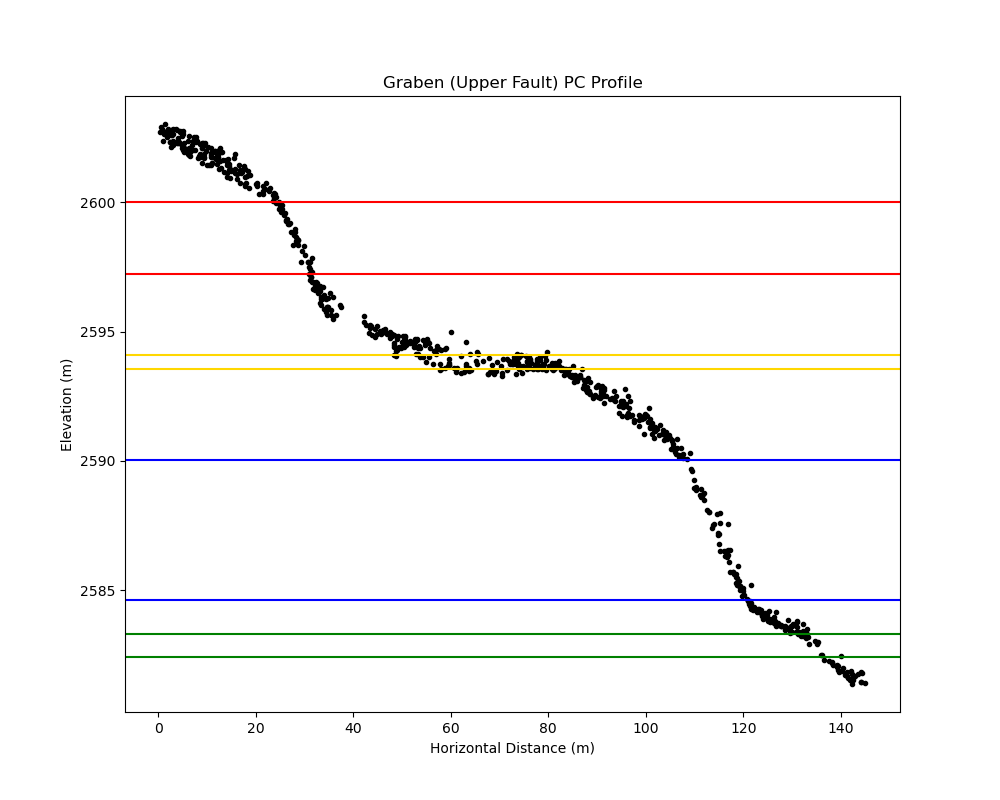

In [12]:

f,axs = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

axs.plot(horiz_pts_list[3],elev_pts_list[3],'.',color = 'k')

axs.axhline(y =  2600.00, color = 'r', linestyle = '-')
axs.axhline(y = 2597.22, color = 'r', linestyle = '-')

axs.axhline(y =  2593.55, color = 'gold', linestyle = '-')
axs.axhline(y = 2594.09, color = 'gold', linestyle = '-')

axs.axhline(y =  2590.03, color = 'b', linestyle = '-')
axs.axhline(y = 2584.63, color = 'b', linestyle = '-')

axs.axhline(y =  2583.31, color = 'g', linestyle = '-')
axs.axhline(y = 2582.44, color = 'g', linestyle = '-')

axs.set_title(loc_list[3] + ' PC Profile')
axs.set_xlabel('Horizontal Distance (m)')
axs.set_ylabel('Elevation (m)')


0.0


Text(0, 0.5, 'Elevation (m)')

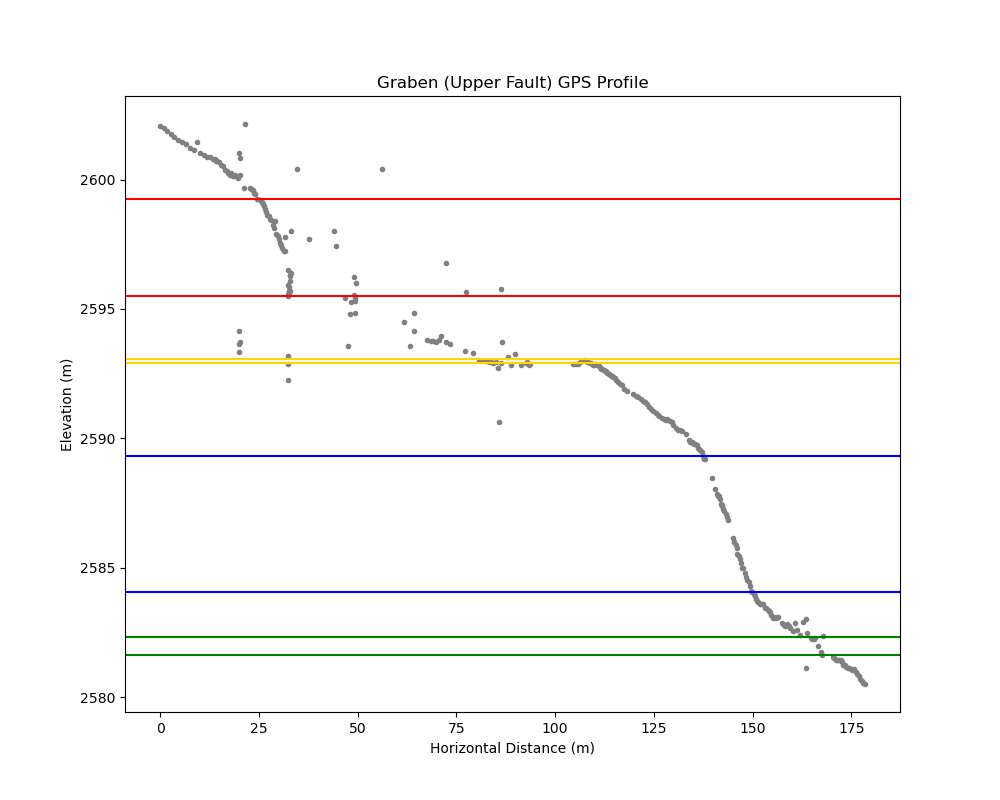

In [18]:
# GPS Profile
# Convert geometries to np arrays
GrabenU_GPS
x,y = GrabenU_GPS.geometry.x,GrabenU_GPS.geometry.y
PointsXY = [np.array(t) for t in zip(x,y)]

xL,yL = GrabenU_Line.geometry[GrabenU_Line.geometry.index[0]].xy
LineXY = [np.array(t) for t in zip(x,y)]

#compare line & point locations to check placement
print(np.sum((LineXY[0] - PointsXY[0])**2))

GU_proj_dist,GU_profile_dist = pCC.projectPointsOntoLine(LineXY, PointsXY) 
%matplotlib widget
f,ax = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
ax.plot(GU_profile_dist,GrabenU_GPS['Elevation'],'.',color = 'grey', alpha = 1)

ax.axhline(y = 2599.25, color = 'r', linestyle = '-')
ax.axhline(y = 2595.50, color = 'r', linestyle = '-')

ax.axhline(y = 2592.91, color = 'gold', linestyle = '-')
ax.axhline(y = 2593.07, color = 'gold', linestyle = '-')


ax.axhline(y = 2589.32 , color = 'b', linestyle = '-')
ax.axhline(y = 2584.06, color = 'b', linestyle = '-')

ax.axhline(y = 2582.32, color = 'g', linestyle = '-')
ax.axhline(y = 2581.63, color = 'g', linestyle = '-')

ax.set_title(loc_list[3] + ' GPS Profile')
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')

### Lower Graben

No such comm: 666d3df893d449e89d9b8d3484e0a6b9


Text(0, 0.5, 'Elevation (m)')

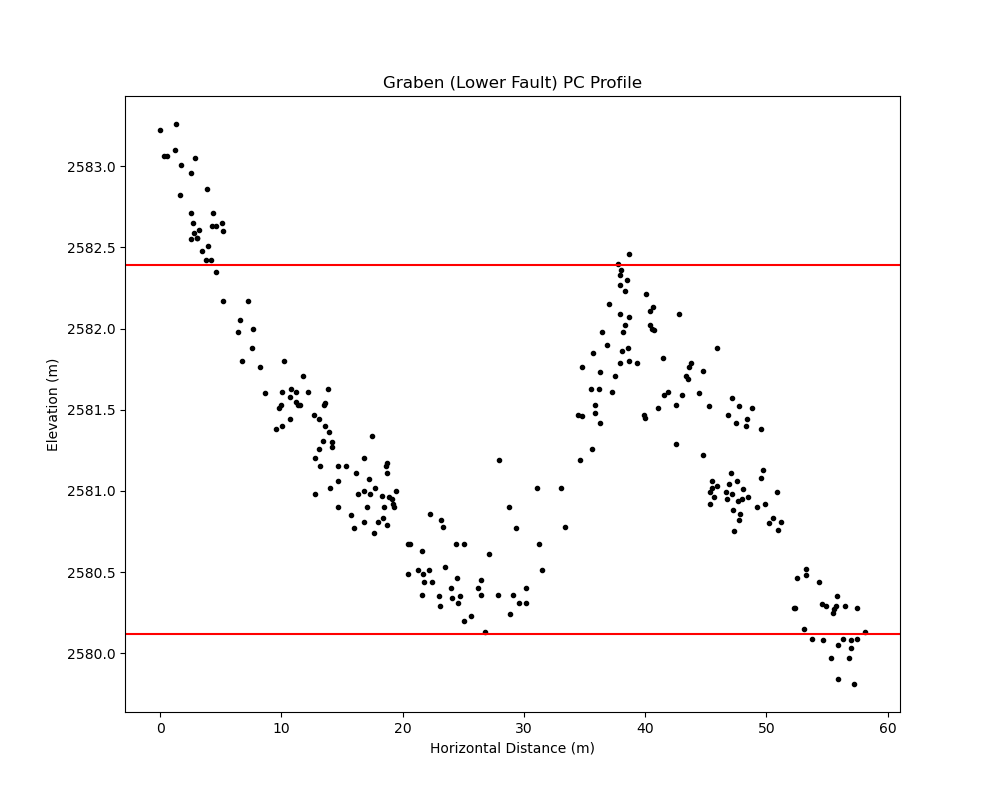

In [14]:
# LIDAR PC PROFILE
f,axs = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

axs.plot(horiz_pts_list[4],elev_pts_list[4],'.',color = 'k')
axs.set_title(loc_list[4] + ' PC Profile')

axs.axhline(y =  2582.39, color = 'r', linestyle = '-')
axs.axhline(y = 2580.12, color = 'r', linestyle = '-')

axs.set_xlabel('Horizontal Distance (m)')
axs.set_ylabel('Elevation (m)')

0.0


Text(0, 0.5, 'Elevation (m)')

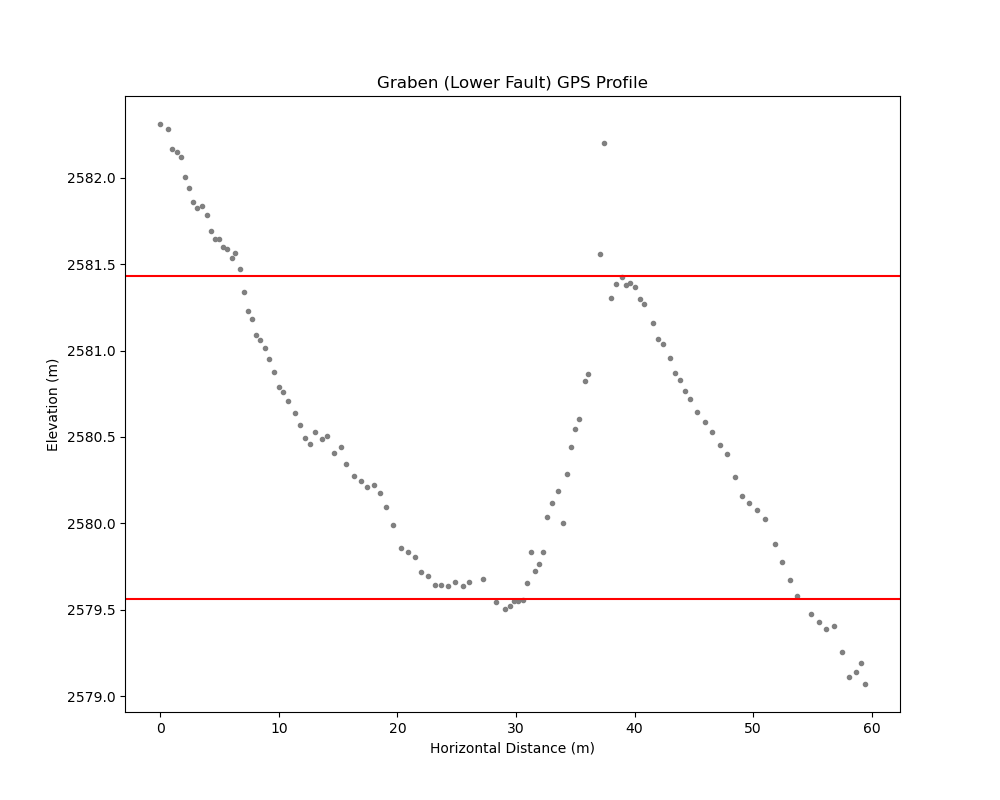

In [15]:
#GPS PROFILE
# Convert geometries to np arrays
x,y = GrabenL_GPS.geometry.x,GrabenL_GPS.geometry.y
PointsXY = [np.array(t) for t in zip(x,y)]

xL,yL = GrabenL_Line.geometry[GrabenL_Line.geometry.index[0]].xy
LineXY = [np.array(t) for t in zip(x,y)]

#compare line & point locations to check placement
print(np.sum((LineXY[0] - PointsXY[0])**2))

GL_proj_dist,GL_profile_dist = pCC.projectPointsOntoLine(LineXY, PointsXY) 
%matplotlib widget
f,ax = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
ax.plot(GL_profile_dist,GrabenL_GPS['Elevation'],'.',color = 'grey', alpha = 1)

ax.axhline(y = 2581.43, color = 'r', linestyle = '-')
ax.axhline(y = 2579.56, color = 'r', linestyle = '-')

ax.set_title(loc_list[4] + ' GPS Profile')
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')

# TOBIN STUDY SITE

No such comm: 4af34637d89944d9a9a6945bca74412c


Text(0, 0.5, 'Elevation (m)')

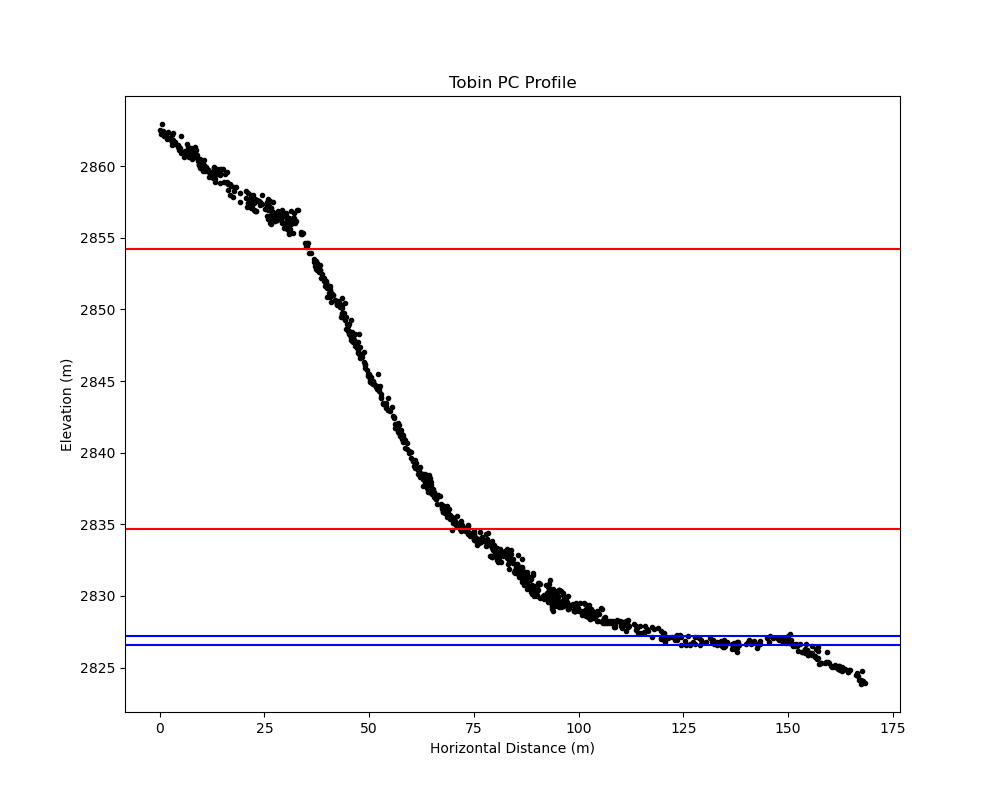

In [16]:
# LIDAR PC PROFILE
f,axs = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

axs.plot(horiz_pts_list[5],elev_pts_list[5],'.',color = 'k')

axs.axhline(y =2854.20, color = 'r', linestyle = '-')
axs.axhline(y =2834.70, color = 'r', linestyle = '-')

axs.axhline(y =  2827.19, color = 'b', linestyle = '-')
axs.axhline(y = 2826.56, color = 'b', linestyle = '-')

axs.set_title(loc_list[5] + ' PC Profile')
axs.set_xlabel('Horizontal Distance (m)')
axs.set_ylabel('Elevation (m)')

0.0


Text(0, 0.5, 'Elevation (m)')

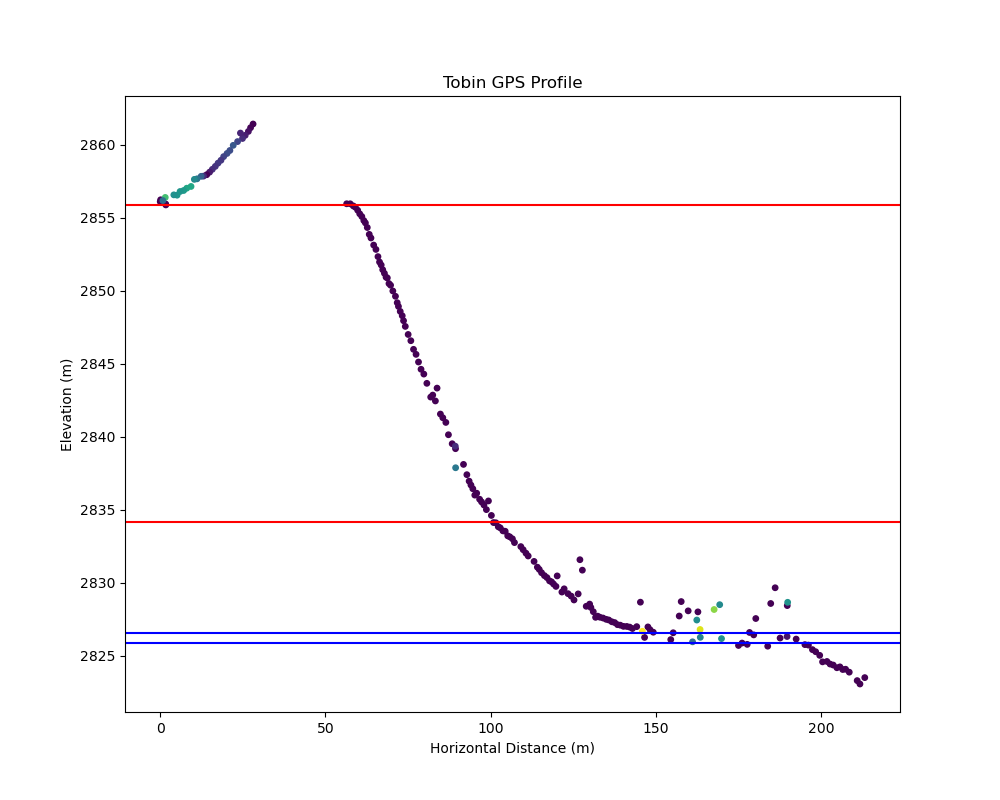

In [17]:
# GPS PROFILE
# Convert geometries to np arrays

x,y = Tobin_GPS.geometry.x,Tobin_GPS.geometry.y
PointsXY = [np.array(t) for t in zip(x,y)]

xL,yL = Tobin_Line.geometry[Tobin_Line.geometry.index[0]].xy
LineXY = [np.array(t) for t in zip(x,y)]

#compare line & point locations to check placement
print(np.sum((LineXY[0] - PointsXY[0])**2))

Tob_proj_dist,Tob_profile_dist = pCC.projectPointsOntoLine(LineXY, PointsXY) 
%matplotlib widget
f,ax = plt.subplots(1,1,figsize =(10,8),dpi = 100,sharex = False,sharey = False)
ax.scatter(Tob_profile_dist,Tobin_GPS['Elevation'], 15, Tob_proj_dist)#'.',color = 'grey', alpha = 1)

ax.axhline(y = 2855.87, color = 'r', linestyle = '-')
ax.axhline(y = 2834.16, color = 'r', linestyle = '-')

ax.axhline(y = 2825.88 , color = 'b', linestyle = '-')
ax.axhline(y = 2826.56, color = 'b', linestyle = '-')


ax.set_title(loc_list[5] + ' GPS Profile')
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')

No such comm: 3c4e043cbac14070b7fc0bfd39a80d95
